### Question 2 Import Libraries

In [11]:
import kornia
import torch
import matplotlib.pyplot as plt
import numpy as np
import queue

### Question 1 Part 1 (MyCanny without hysteresis)

In [12]:
def MyCanny(img, sd, threshold) -> torch.tensor:

    ## apply gaussian smoothing
    img = kornia.filters.gaussian_blur2d(img, (7, 7), (sd, sd))

    ## vectorized calculation of grad_x and grad_y with reference to Pedro Felzenszwalb's handout
    grad_x = img[0, 0, :, 2:] - img[0, 0, :, :-2]

    padding = (1, 1, 0, 0)
    grad_x = torch.nn.functional.pad(grad_x, padding, mode='constant', value=0)

    grad_y = img[0, 0, 2:, :] - img[0, 0, :-2, :]

    padding = (0, 0, 1, 1)
    grad_y = torch.nn.functional.pad(grad_y, padding, mode='constant', value=0)

    ## calculation of gradient magnitude (gm) and gradient direction (gd)
    gm = torch.sqrt(grad_x**2 + grad_y**2)
    gd = torch.atan2(grad_y, grad_x)

    suppressed = torch.zeros_like(gm)

    ## convert gradient direction from [-pi, pi] to [-180, 180]
    gd_degree = gd * (180 / np.pi)

    ## non-maximum suppression
    for row in range(1, gm.shape[0] - 1):
      for col in range(1, gm.shape[1] - 1):

          direction_degree = gd_degree[row, col]

          ## horizontal direction
          if (-22.5 <= direction_degree < 22.5) or (157.5 <= direction_degree < 180) or (-180 <= direction_degree < -157.5):
              d1 = (row, col - 1)
              d2 = (row, col + 1)

          ## diagonal direction (top right to bottom left)
          elif (22.5 <= direction_degree < 67.5) or (-157.5 <= direction_degree < -112.5):
              d1 = (row + 1, col - 1)
              d2 = (row - 1, col + 1)
          
          ## vertical direction
          elif (67.5 <= direction_degree < 112.5) or (-112.5 <= direction_degree < -67.5):
              d1 = (row - 1, col)
              d2 = (row + 1, col)
          
          ## diagonal direction (top left to bottom right)
          else:
              d1 = (row - 1, col - 1)
              d2 = (row + 1, col + 1)

          if max(gm[d1[0], d1[1]], gm[row, col], gm[d2[0], d2[1]]) == gm[row, col]:
              suppressed[row, col] = gm[row, col]

    suppressed_final = torch.where(suppressed >= threshold, True, False)

    return suppressed_final

In [13]:
## reading the image
img = plt.imread('bowl-of-fruit.jpg')
img = img.astype(np.float32) / 255.

## converting from numpy to tensor
img = kornia.image_to_tensor(img.copy())

## converting from rgb to grayscale
img = kornia.color.rgb_to_grayscale(img).unsqueeze(0)

img_canny = MyCanny(img, 10, 0.035)

torch.Size([1, 1312, 1600])


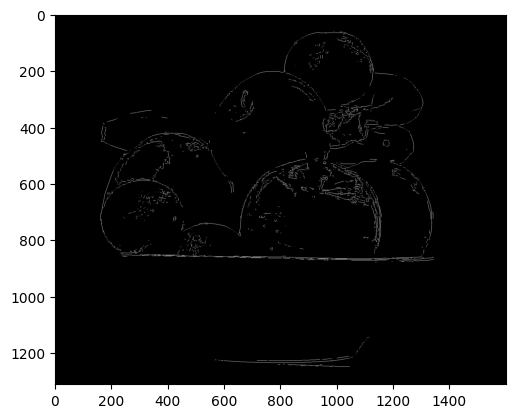

In [14]:
img_canny = img_canny.unsqueeze(0)
print(img_canny.shape)
img_canny = img_canny.permute(1, 2, 0)
img_canny = img_canny.cpu().numpy()
plt.imshow(img_canny, cmap='gray')

In [15]:
## reading the image
img = plt.imread('lego.jpg')
img = img.astype(np.float32) / 255.

## converting from numpy to tensor
img = kornia.image_to_tensor(img.copy())

## converting from rgb to grayscale
img = kornia.color.rgb_to_grayscale(img).unsqueeze(0)

img_canny_lego = MyCanny(img, 10, 0.06)

torch.Size([1, 225, 225])


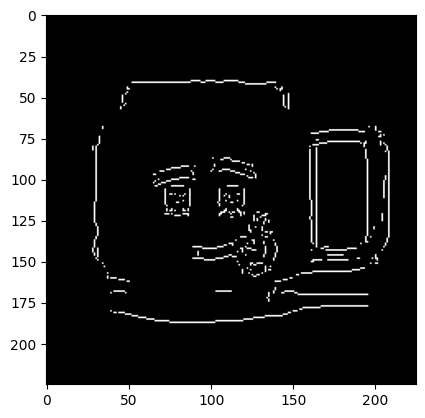

In [16]:
img_canny_lego = img_canny_lego.unsqueeze(0)
print(img_canny_lego.shape)
img_canny_lego = img_canny_lego.permute(1, 2, 0)
img_canny_lego = img_canny_lego.cpu().numpy()
plt.imshow(img_canny_lego, cmap='gray')

### Question 1 Part 2 (MyCannyFull)

In [17]:
def MyCannyFull(img, sd, high_threshold, low_threshold):

    ## apply gaussian smoothing
    img = kornia.filters.gaussian_blur2d(img, (7, 7), (sd, sd))

    ## vectorized calculation of grad_x and grad_y with reference to Pedro Felzenszwalb's handout
    grad_x = img[0, 0, :, 2:] - img[0, 0, :, :-2]

    padding = (1, 1, 0, 0)
    grad_x = torch.nn.functional.pad(grad_x, padding, mode='constant', value=0)

    grad_y = img[0, 0, 2:, :] - img[0, 0, :-2, :]

    padding = (0, 0, 1, 1)
    grad_y = torch.nn.functional.pad(grad_y, padding, mode='constant', value=0)

    ## calculation of gradient magnitude (gm) and gradient direction (gd)
    gm = torch.sqrt(grad_x**2 + grad_y**2)
    gd = torch.atan2(grad_y, grad_x)

    suppressed = torch.zeros_like(gm)

    ## convert gradient direction to [-180, 180]
    gd_degree = gd * (180 / np.pi)

    ## non-maximum suppression
    for row in range(1, gm.shape[0] - 1):
      for col in range(1, gm.shape[1] - 1):

          direction_degree = gd_degree[row, col]

          ## horizontal direction
          if (-22.5 <= direction_degree < 22.5) or (157.5 <= direction_degree < 180) or (-180 <= direction_degree < -157.5):
              d1 = (row, col - 1)
              d2 = (row, col + 1)

          ## diagonal direction (top right to bottom left)
          elif (22.5 <= direction_degree < 67.5) or (-157.5 <= direction_degree < -112.5):
              d1 = (row + 1, col - 1)
              d2 = (row - 1, col + 1)
          
          ## vertical direction
          elif (67.5 <= direction_degree < 112.5) or (-112.5 <= direction_degree < -67.5):
              d1 = (row - 1, col)
              d2 = (row + 1, col)
          
          ## diagonal direction (top left to bottom right)
          else:
              d1 = (row - 1, col - 1)
              d2 = (row + 1, col + 1)

          if max(gm[d1[0], d1[1]], gm[row, col], gm[d2[0], d2[1]]) == gm[row, col]:
              suppressed[row, col] = gm[row, col]

    ## hysteresis with high and low threshold
    discovered = torch.zeros((suppressed.shape[0], suppressed.shape[1]), dtype=torch.bool)
    final_edges = torch.zeros((suppressed.shape[0], suppressed.shape[1]), dtype=torch.bool)
    bfs_queue = queue.Queue()

    ## marking strong edges
    for row in range(suppressed.shape[0]):
        for col in range(suppressed.shape[1]):
            if suppressed[row, col] >= high_threshold:
                discovered[row, col] = True
                final_edges[row, col] = True
                bfs_queue.put((row, col))

    neighbours = [(-1, -1), (-1, 0), (-1, 1), 
                  (0, -1), (0, 1),
                  (1, -1), (1, 0), (1, 1)]

    ## iterate through the queue by marking weak edges
    while not bfs_queue.empty():
        r0, c0, = bfs_queue.get()

        for r1, c1 in neighbours:
            if (not discovered[r0 + r1, c0 + c1]) and suppressed[r0 + r1, c0 + c1] >= low_threshold:
                discovered[r0 + r1, c0 + c1] = True
                final_edges[r0 + r1, c0 + c1] = True
                bfs_queue.put((r0 + r1, c0 + c1))

    return final_edges


In [18]:
## reading the image
img = plt.imread('bowl-of-fruit.jpg')
img = img.astype(np.float32) / 255.

## converting from numpy to tensor
img = kornia.image_to_tensor(img.copy())

## converting from rgb to grayscale
img = kornia.color.rgb_to_grayscale(img).unsqueeze(0)

img_canny = MyCannyFull(img, 10, 0.035, 0.01)

torch.Size([1, 1312, 1600])


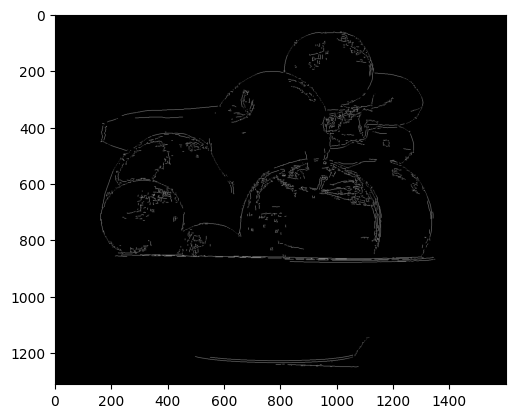

In [19]:
resized_img_h_a = img_canny.unsqueeze(0)
print(resized_img_h_a.shape)
resized_img_h_a = resized_img_h_a.permute(1, 2, 0)
resized_img_h_a = resized_img_h_a.cpu().numpy()
plt.imshow(resized_img_h_a, cmap='gray')

In [20]:
## reading the image
img = plt.imread('lego.jpg')
img = img.astype(np.float32) / 255.

## converting from numpy to tensor
img = kornia.image_to_tensor(img.copy())

## converting from rgb to grayscale
img = kornia.color.rgb_to_grayscale(img).unsqueeze(0)

img_canny_lego = MyCannyFull(img, 10, 0.035, 0.01)

torch.Size([1, 225, 225])


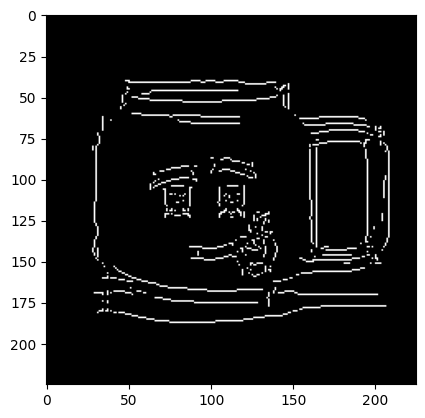

In [21]:
img_canny_lego = img_canny_lego.unsqueeze(0)
print(img_canny_lego.shape)
img_canny_lego = img_canny_lego.permute(1, 2, 0)
img_canny_lego = img_canny_lego.cpu().numpy()
plt.imshow(img_canny_lego, cmap='gray')